<h1>Feather Tutorial</h1>

In [2]:
# download base images
from toolviper.utils.data import download

download("feather_sim_sd_c1_pI.im")
download("feather_sim_vla_c1_pI.im")

[2025-08-15 17:08:38,199]     INFO  graphviper:  Downloading from [cloudflare] .... 


 Download List            
 ───────────────────────── 
  feather_sim_sd_c1_pI.im

Output()

[2025-08-15 17:08:40,075]     INFO  graphviper:  Downloading from [cloudflare] .... 


 Download List             
 ────────────────────────── 
  feather_sim_vla_c1_pI.im

[2025-08-15 17:08:40,077]     INFO  graphviper:  File exists: feather_sim_vla_c1_pI.im 


Output()

The required input images should be generated using feather_tutorial_create_initial_images.ipynb

In [3]:
from toolviper.dask.client import local_client
log_params = {'log_level':'DEBUG'}
worker_log_params = {'log_level':'DEBUG'}
viper_client = local_client(cores=1, memory_limit="8.0GiB",log_params=log_params,worker_log_params=worker_log_params)
#viper_client = local_client(serial_execution=True)
# viper_client

from astroviper.imaging import feather
#feather(outim={"name": "feathered_image.img.zarr", "format": "zarr", "overwrite": True}, highres= 'int.zarr', lowres= 'sd.zarr', sdfactor=1)
feather(outim={"name": "feathered_image.img.zarr", "format": "zarr", "overwrite": True}, highres= 'feather_sim_vla_c1_pI.im', lowres= 'feather_sim_sd_c1_pI.im', sdfactor=1)

[2025-08-15 17:08:42,385]     INFO  graphviper:  Module path: /Users/jsteeb/Dropbox/toolviper/src/toolviper 
[2025-08-15 17:08:42,390]  WARNING  graphviper:  It is recommended that the local cache directory be set using the dask_local_dir parameter. 
[2025-08-15 17:08:42,408]    DEBUG    worker_0:  Logger created on worker Worker-f7985a4f-fc03-4b7f-97dc-03b3288a62d2,*,tcp://127.0.0.1:62880
[2025-08-15 17:08:42,408]    DEBUG    worker_0:  Logger created on worker Worker-f7985a4f-fc03-4b7f-97dc-03b3288a62d2,*,tcp://127.0.0.1:62880
[2025-08-15 17:08:42,409]     INFO  graphviper:  Client <MenrvaClient: 'tcp://127.0.0.1:62873' processes=1 threads=1, memory=8.00 GiB> 
[2025-08-15 17:08:43,678]     INFO  graphviper:  J2000 found as system reference frame in CASA image This corresponds to fk5(equinox="j2000") in astropy. Metadata will be written appropriately 
Successful readonly open of default-locked table feather_sim_sd_c1_pI.im: 1 columns, 1 rows
[2025-08-15 17:08:43,684]     INFO  graphvi

INFO:graphviper:Time to compute() feather 5.377545118331909s


(1, 1, 1, 4096, 4096)


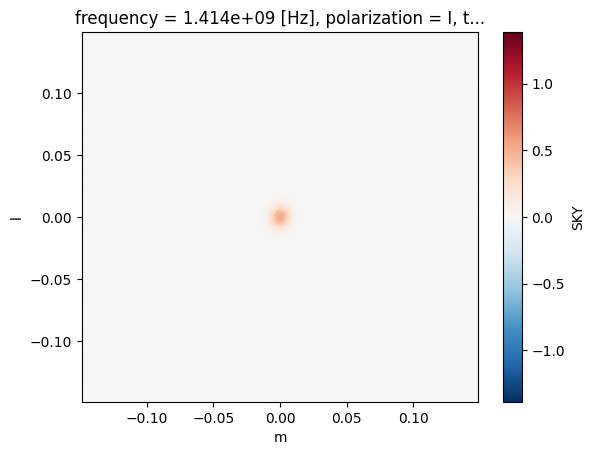

In [4]:
from xradio.image import load_image, read_image
feather_xds = load_image("feathered_image.img.zarr")
print(feather_xds.SKY.shape)

import numpy as np
np.nanmax(np.abs(feather_xds.SKY.values))
feather_xds.SKY.isel(polarization=0,frequency=0).plot()

In [5]:
feather_xds
# feather_xds.BEAM.shape

<xarray.Dataset> Size: 336MB
Dimensions:          (time: 1, frequency: 1, polarization: 1, beam_param: 3,
                      l: 4096, m: 4096)
Coordinates:
  * beam_param       (beam_param) <U5 60B 'major' 'minor' 'pa'
    declination      (l, m) float64 134MB -0.1495 -0.1494 ... 0.1493 0.1494
  * frequency        (frequency) float64 8B 1.414e+09
  * l                (l) float64 33kB 0.1489 0.1489 0.1488 ... -0.1488 -0.1489
  * m                (m) float64 33kB -0.1489 -0.1489 -0.1488 ... 0.1488 0.1489
  * polarization     (polarization) <U1 4B 'I'
    right_ascension  (l, m) float64 134MB 0.1512 0.1512 0.1512 ... 6.132 6.132
  * time             (time) float64 8B 5.876e+04
    velocity         (frequency) float64 8B 2.119e+05
Data variables:
    BEAM             (time, frequency, polarization, beam_param) float64 24B ...
    SKY              (time, frequency, polarization, l, m) float32 67MB -0.00...
Attributes:
    direction:  {'latpole': {'attrs': {'type': 'quantity', 'units': 'rad'}, '...